[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tranngocduvnvp/CTCDFormer/blob/main/CTDCFormerB4.ipynb)

# Setup

In [1]:
!pip install dropblock

  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached torch-2.1.1-cp38-cp38-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached filelock-3.13.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached fsspec-2023.12.2-py3-none-any.whl.metadata (6.8 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 215.7 kB/s eta 0:00:00a 0:00:01
  Using cached torchvision-0.16.1-cp38-cp38-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
  Using cached safetensors-0.4.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached Pillow-10.1.0-cp38-cp38-manylinux_2_28_x86_64.whl.metadata (9.5 kB)
  Using cached charset_normalizer-3.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (33 kB)
  Using cached idna-3.6-py3-none-any.whl.metadata (9.9 kB)
  Using cached urllib3-2.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached certifi-2023.11.17-py3-none-any.whl.metadata (2.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 195.6 kB/s eta 0:00:00a 0:00:01


In [4]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 1.2 MB/s eta 0:00:00a 0:00:01m


# Import thư viện

In [1]:
import random
import cv2
import torch
from torch.utils import data
import torchvision.transforms.functional as TF
import numpy as np
import random
import multiprocessing
# import timm
import torchmetrics
import sys
import os
import argparse
import time
import numpy as np
from PIL import Image
import glob

import torch.nn as nn
import torchmetrics.functional.classification as Fmstric
import torchgeometry as tgm
# from torchsummary import summary


import torch.nn.functional as F
# from functools import partial
# from timm.models.vision_transformer import _cfg

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from dropblock import DropBlock2D


# Config

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(55581)

Random seed set as 55581


In [3]:
class Args:
    def __init__(self,root, epochs, batch_size, dataset, mgpu, lrs_min,\
                 lrs, lr, type_lr, checkpoint_path, encoder_block, optim, img_size, mini_batch):
        self.root = root
        self.epochs = epochs
        self.batch_size = batch_size
        self.dataset = dataset
        self.mgpu = mgpu
        self.lrs_min = lrs_min
        self.lrs = lrs
        self.lr = lr
        self.type_lr = type_lr
        self.checkpoint_path = checkpoint_path
        self.encoder_block = encoder_block
        self.optim = optim
        self.img_size = img_size
        self.mini_batch = mini_batch
model_name = input("model name:")
args = Args(
    root="/home/bigdata/Documents/TND_Modeling/dataset",
    epochs=200,
    batch_size=16,
    dataset=model_name,
    mgpu="false",
    lrs="true",
    lrs_min=1e-6,
    lr = 1e-4,
    type_lr = "StepLR",
    checkpoint_path = None,
    encoder_block="DSMNet",
    optim="NAdam",
    img_size = 256,
    mini_batch =16
)
args.root

'/home/bigdata/Documents/TND_Modeling/dataset'

# Make Dataset

In [4]:
class SegDataset(data.Dataset):
    def __init__(
        self,
        input_paths: list,
        target_paths: list,
        transform_input=None,
        transform_target=None,
        hflip=False,
        vflip=False,
        affine=False,
    ):
        self.input_paths = input_paths
        self.target_paths = target_paths
        self.transform_input = transform_input
        self.transform_target = transform_target
        self.hflip = hflip
        self.vflip = vflip
        self.affine = affine

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, index: int):
        input_ID = self.input_paths[index]
        target_ID = self.target_paths[index]

        x = cv2.cvtColor(cv2.imread(input_ID), cv2.COLOR_BGR2RGB)
        y = cv2.cvtColor(cv2.imread(target_ID), cv2.COLOR_BGR2RGB)
        x = self.transform_input(x)
        y = self.transform_target(y)

        if self.hflip:
            if random.uniform(0.0, 1.0) > 0.5:
                x = TF.hflip(x)
                y = TF.hflip(y)

        if self.vflip:
            if random.uniform(0.0, 1.0) > 0.5:
                x = TF.vflip(x)
                y = TF.vflip(y)

        if self.affine:
            angle = random.uniform(-180.0, 180.0)
            h_trans = random.uniform(-args.img_size / 16, args.img_size / 16)
            v_trans = random.uniform(-args.img_size / 16, args.img_size / 16)
            scale = random.uniform(0.7, 1.2)
            shear = random.uniform(-10.5, 10.5)
            x = TF.affine(x, angle, (h_trans, v_trans), scale, shear, fill=-1.0)
            y = TF.affine(y, angle, (h_trans, v_trans), scale, shear, fill=0.0)
        return x.float(), y.float()

class QU_Dataset(data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, state=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform


    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self, index):
        img_path = self.image_dir[index]
        mask_path = self.mask_dir[index]
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))
        mask[mask >= 1] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask.unsqueeze(0).float()



In [5]:
def get_dataloader_lung(root=args.root, batch_size = 4):
    
    DATA_NAME = ["Darwin", "Montgomery", "Shenzhen"]
    list_img_paths = [glob.glob(f"{root}/{name}/img/*") for name in DATA_NAME]
    list_mask_paths = [glob.glob(f"{root}/{name}/mask/*") for name in DATA_NAME]
    
    train_img = []
    val_img = []
    test_img = []
    train_mask = []
    val_mask = []
    test_mask = []

   
    for img_dataset, mask_dataset in zip(list_img_paths, list_mask_paths):
     
        img_train_val, img_test, mask_train_val, mask_test = train_test_split(img_dataset, mask_dataset, test_size=0.1, random_state=42)
        img_train, img_val, mask_train, mask_val = train_test_split(img_train_val, mask_train_val, test_size=1 - 0.8/0.9, random_state=42)

        # Gộp vào các list tương ứng
        train_img.extend(img_train)
        val_img.extend(img_val)
        test_img.extend(img_test)
        train_mask.extend(mask_train)
        val_mask.extend(mask_val)
        test_mask.extend(mask_test)

    IMAGE_HEIGHT = args.img_size
    IMAGE_WIDTH = args.img_size
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=20, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.GaussianBlur (),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                #mean = (0.485, 0.456, 0.406),
                #std = (0.229, 0.224, 0.225),
                mean = (0., 0., 0.),
                std = (1., 1., 1.),
                max_pixel_value = 255.0
            ),
            ToTensorV2(),
        ])
    val_transform = A.Compose(
        [
            #A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean = (0., 0., 0.),
                std = (1., 1., 1.),
                max_pixel_value = 255.0
            ),
            ToTensorV2(),
        ])

    train_data = QU_Dataset(train_img,train_mask,transform=train_transform)
    val_data = QU_Dataset(val_img,val_mask,transform=val_transform)
    test_data = QU_Dataset(test_img,test_mask,transform=val_transform)

    train_dataloader = data.DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=multiprocessing.Pool()._processes,
    )
    
    val_dataloader = data.DataLoader(
        dataset=val_data,
        batch_size=1,
        shuffle=False,
        num_workers=multiprocessing.Pool()._processes,
    )
    
    test_dataloader = data.DataLoader(
        dataset=test_data,
        batch_size=1,
        shuffle=False,
        num_workers=multiprocessing.Pool()._processes,
    )

    return train_dataloader, val_dataloader, test_dataloader




# BOWL2018

In [6]:
train_dataloader, val_dataloader, test_dataloader = get_dataloader_lung()

In [7]:
print("len data train:", len(train_dataloader.dataset))
print("len data val:", len(val_dataloader.dataset))
print("len data test:", len(test_dataloader.dataset))

len data train: 5446
len data val: 682
len data test: 682


image.shape: torch.Size([1, 3, 256, 256])
mask.shape; torch.Size([1, 1, 256, 256])
image.max:0.9960784912109375, image.min:0.0
mask.max:1.0, mask.min:0.0, mask.unique:tensor([0., 1.])


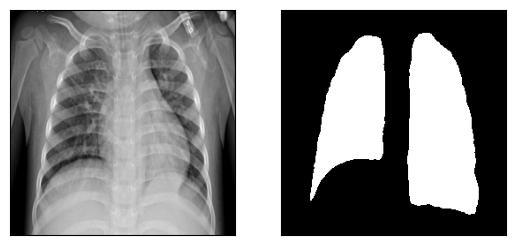

In [8]:
image, mask = next(iter(test_dataloader))
print("image.shape:", image.shape)
print("mask.shape;", mask.shape)
print(f"image.max:{torch.max(image)}, image.min:{torch.min(image)}")
print(f"mask.max:{torch.max(mask)}, mask.min:{torch.min(mask)}, mask.unique:{torch.unique(mask)}")
      
plt.subplot(1,2,1)
plt.imshow(image[0].permute(1,2,0))
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(mask[0][0],cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

# Model

## ConvUnet

In [ ]:
from typing import Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class Conv(nn.Module):
    def __init__(self, dim):
        super(Conv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, stride=1, groups=dim, padding_mode='reflect') # depthwise conv
        self.norm1 = nn.BatchNorm2d(dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # pointwise/1x1 convs, implemented with linear layers
        self.act1 = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.norm2 = nn.BatchNorm2d(dim)
        self.act2 = nn.GELU()
    def forward(self, x):
        residual = x
        x = self.dwconv(x)
        x = self.norm1(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.pwconv1(x)
        x = self.act1(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
        x = self.norm2(x)
        x = self.act2(residual + x)

        return x


class Down(nn.Sequential):
    def __init__(self, in_channels, out_channels, layer_num=1):
        layers = nn.ModuleList()
        for i in range(layer_num):
            layers.append(Conv(out_channels))
        super(Down, self).__init__(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2),
            *layers
        )


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True, layer_num=1):
        super(Up, self).__init__()
        C = in_channels // 2
        self.norm = nn.BatchNorm2d(C)
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.gate = nn.Linear(C, 3 * C)
        self.linear1 = nn.Linear(C, C)
        self.linear2 = nn.Linear(C, C)
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        layers = nn.ModuleList()
        for i in range(layer_num):
            layers.append(Conv(out_channels))
        self.conv = nn.Sequential(*layers)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.norm(x1)
        x1 = self.up(x1)
        # [N, C, H, W]
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        # padding_left, padding_right, padding_top, padding_bottom
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])
        #attention
        B, C, H, W = x1.shape
        x1 = x1.permute(0, 2, 3, 1)
        x2 = x2.permute(0, 2, 3, 1)
        gate = self.gate(x1).reshape(B, H, W, 3, C).permute(3, 0, 1, 2, 4)
        g1, g2, g3 = gate[0], gate[1], gate[2]
        x2 = torch.sigmoid(self.linear1(g1 + x2)) * x2 + torch.sigmoid(g2) * torch.tanh(g3)
        x2 = self.linear2(x2)
        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)

        x = self.conv1x1(torch.cat([x2, x1], dim=1))
        x = self.conv(x)
        return x


class OutConv(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(OutConv, self).__init__(
            nn.Conv2d(in_channels, num_classes, kernel_size=1)
        )


class ConvUNeXt(nn.Module):
    def __init__(self,
                 in_channels: int = 3,
                 num_classes: int = 1,
                 bilinear: bool = True,
                 base_c: int = 32):
        super(ConvUNeXt, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear

        self.in_conv = nn.Sequential(
            nn.Conv2d(in_channels, base_c, kernel_size=7, padding=3, padding_mode='reflect'),
            nn.BatchNorm2d(base_c),
            nn.GELU(),
            Conv(base_c)
        )
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = Down(base_c * 4, base_c * 8, layer_num=3)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_c * 8, base_c * 16 // factor)
        self.up1 = Up(base_c * 16, base_c * 8 // factor, bilinear)
        self.up2 = Up(base_c * 8, base_c * 4 // factor, bilinear)
        self.up3 = Up(base_c * 4, base_c * 2 // factor, bilinear)
        self.up4 = Up(base_c * 2, base_c, bilinear)
        self.out_conv = OutConv(base_c, num_classes)

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.out_conv(x)

        return out

Convunet = ConvUNeXt()

## Unetplusplus

In [ ]:
import torch
from torch import nn

__all__ = ['UNet', 'NestedUNet']


class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        self.conv2_2 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv1_3 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv0_4 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, self.up(x1_3)], 1))

        output = self.final(x0_4)
        return output


class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output
Unetplusplus = NestedUNet(1)

## Double Unet

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19

class Conv2D(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1, dilation=1, bias=False, act=True):
        super().__init__()
        self.act = act

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_c, out_c,
                kernel_size=kernel_size,
                padding=padding,
                dilation=dilation,
                bias=bias
            ),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.act == True:
            x = self.relu(x)
        return x


class squeeze_excitation_block(nn.Module):
    def __init__(self, in_channels, ratio=8):
        super().__init__()

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels//ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels//ratio, in_channels),
            nn.Sigmoid()
        )


    def forward(self, x):
        batch_size, channel_size, _, _ = x.size()
        y = self.avgpool(x).view(batch_size, channel_size)
        y = self.fc(y).view(batch_size, channel_size, 1, 1)
        return x*y.expand_as(x)

class ASPP(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.avgpool = nn.Sequential(
            nn.AdaptiveAvgPool2d((2, 2)),
            Conv2D(in_c, out_c, kernel_size=1, padding=0)
        )

        self.c1 = Conv2D(in_c, out_c, kernel_size=1, padding=0, dilation=1)
        self.c2 = Conv2D(in_c, out_c, kernel_size=3, padding=6, dilation=6)
        self.c3 = Conv2D(in_c, out_c, kernel_size=3, padding=12, dilation=12)
        self.c4 = Conv2D(in_c, out_c, kernel_size=3, padding=18, dilation=18)

        self.c5 = Conv2D(out_c*5, out_c, kernel_size=1, padding=0, dilation=1)

    def forward(self, x):
        x0 = self.avgpool(x)
        x0 = F.interpolate(x0, size=x.size()[2:], mode="bilinear", align_corners=True)

        x1 = self.c1(x)
        x2 = self.c2(x)
        x3 = self.c3(x)
        x4 = self.c4(x)

        xc = torch.cat([x0, x1, x2, x3, x4], axis=1)
        y = self.c5(xc)

        return y

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.c1 = Conv2D(in_c, out_c)
        self.c2 = Conv2D(out_c, out_c)
        self.a1 = squeeze_excitation_block(out_c)

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.a1(x)
        return x

class encoder1(nn.Module):
    def __init__(self):
        super().__init__()

        network = vgg19(pretrained=True)
        # print(network)

        self.x1 = network.features[:4]
        self.x2 = network.features[4:9]
        self.x3 = network.features[9:18]
        self.x4 = network.features[18:27]
        self.x5 = network.features[27:36]

    def forward(self, x):
        x0 = x
        x1 = self.x1(x0)
        x2 = self.x2(x1)
        x3 = self.x3(x2)
        x4 = self.x4(x3)
        x5 = self.x5(x4)
        return x5, [x4, x3, x2, x1]

class decoder1(nn.Module):
    def __init__(self):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.c1 = conv_block(64+512, 256)
        self.c2 = conv_block(512, 128)
        self.c3 = conv_block(256, 64)
        self.c4 = conv_block(128, 32)

    def forward(self, x, skip):
        s1, s2, s3, s4 = skip

        x = self.up(x)
        x = torch.cat([x, s1], axis=1)
        x = self.c1(x)

        x = self.up(x)
        x = torch.cat([x, s2], axis=1)
        x = self.c2(x)

        x = self.up(x)
        x = torch.cat([x, s3], axis=1)
        x = self.c3(x)

        x = self.up(x)
        x = torch.cat([x, s4], axis=1)
        x = self.c4(x)

        return x

class encoder2(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool = nn.MaxPool2d((2, 2))

        self.c1 = conv_block(3, 32)
        self.c2 = conv_block(32, 64)
        self.c3 = conv_block(64, 128)
        self.c4 = conv_block(128, 256)

    def forward(self, x):
        x0 = x

        x1 = self.c1(x0)
        p1 = self.pool(x1)

        x2 = self.c2(p1)
        p2 = self.pool(x2)

        x3 = self.c3(p2)
        p3 = self.pool(x3)

        x4 = self.c4(p3)
        p4 = self.pool(x4)

        return p4, [x4, x3, x2, x1]

class decoder2(nn.Module):
    def __init__(self):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.c1 = conv_block(832, 256)
        self.c2 = conv_block(640, 128)
        self.c3 = conv_block(320, 64)
        self.c4 = conv_block(160, 32)

    def forward(self, x, skip1, skip2):

        x = self.up(x)
        x = torch.cat([x, skip1[0], skip2[0]], axis=1)
        x = self.c1(x)

        x = self.up(x)
        x = torch.cat([x, skip1[1], skip2[1]], axis=1)
        x = self.c2(x)

        x = self.up(x)
        x = torch.cat([x, skip1[2], skip2[2]], axis=1)
        x = self.c3(x)

        x = self.up(x)
        x = torch.cat([x, skip1[3], skip2[3]], axis=1)
        x = self.c4(x)

        return x

class build_doubleunet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder1()
        self.a1 = ASPP(512, 64)
        self.d1 = decoder1()
        self.y1 = nn.Conv2d(32, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

        self.e2 = encoder2()
        self.a2 = ASPP(256, 64)
        self.d2 = decoder2()
        self.y2 = nn.Conv2d(32, 1, kernel_size=1, padding=0)

    def forward(self, x):
        x0 = x
        x, skip1 = self.e1(x)
        x = self.a1(x)
        x = self.d1(x, skip1)
        y1 = self.y1(x)

        input_x = x0 * self.sigmoid(y1)
        x, skip2 = self.e2(input_x)
        x = self.a2(x)
        x = self.d2(x, skip1, skip2)
        y2 = self.y2(x)

        return y1, y2


Doubleunet = build_doubleunet()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 48.6MB/s] 


## Attention Unet

In [36]:
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class conv_block2(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block2,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block2(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block2(ch_in=64,ch_out=128)
        self.Conv3 = conv_block2(ch_in=128,ch_out=256)
        self.Conv4 = conv_block2(ch_in=256,ch_out=512)
        self.Conv5 = conv_block2(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block2(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block2(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block2(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block2(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

Attenunet = AttU_Net()

## ResUnet

In [ ]:
class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)



class ResUnet(nn.Module):
    def __init__(self, channel, filters=[64, 128, 256, 512]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.bridge = ResidualConv(filters[2], filters[3], 2, 1)

        self.upsample_1 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_2 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_3 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 1, 1, 1),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        # Bridge
        x4 = self.bridge(x3)
        # Decode
        x4 = self.upsample_1(x4)
        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample_2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample_3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        output = self.output_layer(x10)

        return output

Resunet = ResUnet(3)

## Unet

In [89]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self, n_class=1):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

unet = UNet(1)

## Unext

In [29]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
# from utils import *
_all_ = ['UNext']

import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
# import types
import math
# from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
# import pdb

import argparse
import torch.nn as nn

class qkv_transform(nn.Conv1d):
    """Conv1d for qkv_transform"""

def str2bool(v):
    if v.lower() in ['true', 1]:
        return True
    elif v.lower() in ['false', 0]:
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)


def shift(dim):
            x_shift = [ torch.roll(x_c, shift, dim) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
            x_cat = torch.cat(x_shift, 1)
            x_cat = torch.narrow(x_cat, 2, self.pad, H)
            x_cat = torch.narrow(x_cat, 3, self.pad, W)
            return x_cat

class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2


        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP

    def __init__(self,  num_classes=1, input_channels=3, deep_supervision=False,img_size=256, patch_size=16, in_chans=3,  embed_dims=[ 128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()

        self.encoder1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.encoder2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.encoder3 = nn.Conv2d(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)

        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(256, 160, 3, stride=1,padding=1)
        self.decoder2 =   nn.Conv2d(160, 128, 3, stride=1, padding=1)
        self.decoder3 =   nn.Conv2d(128, 32, 3, stride=1, padding=1)
        self.decoder4 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)

        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):

        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))

        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3

        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)

        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters

    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()

        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)
        self.encoder2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.encoder3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)

        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 = nn.Conv2d(128, 64, 3, stride=1,padding=1)
        self.decoder2 =   nn.Conv2d(64, 32, 3, stride=1, padding=1)
        self.decoder3 =   nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.decoder4 =   nn.Conv2d(16, 8, 3, stride=1, padding=1)
        self.decoder5 =   nn.Conv2d(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)

        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):

        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))

        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3

        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)

        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


#EOF

Unext=UNext()

/home/bigdata/miniconda3/envs/medical/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## FCN32

In [ ]:
import os.path as osp

import fcn
import numpy as np
import torch
import torch.nn as nn


# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()


class FCN32s(nn.Module):

    pretrained_model = \
        osp.expanduser('~/data/models/pytorch/fcn32s_from_caffe.pth')

    @classmethod
    def download(cls):
        return fcn.data.cached_download(
            url='https://drive.google.com/uc?id=11k2Q0bvRQgQbT6-jYWeh6nmAsWlSCY3f',  # NOQA
            path=cls.pretrained_model,
            md5='d3eb467a80e7da0468a20dfcbc13e6c8',
        )

    def __init__(self, n_class=1):
        super(FCN32s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, stride=32,
                                          bias=False)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)

        h = self.upscore(h)
        h = h[:, :, 19:19 + x.size()[2], 19:19 + x.size()[3]].contiguous()

        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())

fcn32 = FCN32s()
# x = torch.rand((1, 3, 256, 256))
# y = fcn32(x)
# print(y.shape)

# Module

In [9]:
class EFFat(nn.Module):

    def __init__(self, channel=512,reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.GELU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) + self.max_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x) + x


class convMixerLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size) -> None:
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels=in_channel,
            out_channels=in_channel,
            groups=in_channel,
            kernel_size=kernel_size,
            stride=1,
            padding="same"
        )
        self.eff = EFFat(out_channel)
        self.pointwise = nn.Conv2d(in_channel, out_channel, 1, 1)
        self.activation = nn.SiLU()
        self.batchnorm1 = nn.BatchNorm2d(in_channel)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)

    def forward(self, x):
        ori = x
        x = self.depthwise(x)
        x = self.activation(x)
        x = self.eff(self.batchnorm1(x)) + ori
        x = self.pointwise(x)
        x = self.activation(x)
        x = self.batchnorm2(x)
        return x


class SEModule(nn.Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(
            channels, channels // reduction, kernel_size=1, padding=0 ,bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0 ,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))

class Bottleneck(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c2, 3, 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))

class BottleneckCSP(nn.Module):
    # CSP Bottleneck https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = nn.Conv2d(c1, c_, 1, 1, bias=False)
        self.cv3 = nn.Conv2d(c_, c_, 1, 1, bias=False)
        self.cv4 = Conv(2 * c_, c2, 1, 1)
        self.bn = nn.BatchNorm2d(2 * c_)  # applied to cat(cv2, cv3)
        self.act = nn.SiLU()
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        y1 = self.cv3(self.m(self.cv1(x)))
        y2 = self.cv2(x)
        return self.cv4(self.act(self.bn(torch.cat((y1, y2), 1))))

class Layernorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_first"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class Channel_attention(nn.Module):
    def __init__(self, c, reduction=16) -> None:
        super().__init__()
        self.fcap1 = nn.Conv2d(c, c//reduction,1)
        self.fcmp1 = nn.Conv2d(c, c//reduction, 1)
        self.fcap2 = nn.Conv2d(c//reduction, c, 1)
        self.fcmp2 = nn.Conv2d(c//reduction, c, 1)
        self.acg = nn.Conv2d(c//reduction, c, 1)
    def forward(self, x):
        f1 = F.relu(self.fcap1(x))
        f2 = F.relu(self.fcmp1(x))
        f = self.acg(f1 + f2)
        out = F.sigmoid(f + self.fcap2(f1) + self.fcmp2(f2))*x
        return out

class CTblock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3) -> None:
        super().__init__()
        self.mixspatial = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, kernel_size, padding="same", groups=in_channel),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(),
            Channel_attention(in_channel),
            nn.Conv2d(in_channel, out_channel, 3, padding="same"),
            nn.BatchNorm2d(out_channel),
        )
        self.mixchannel = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 1, 1),
            nn.BatchNorm2d(out_channel),
        )

    def forward(self, x):
        y = F.relu(self.mixspatial(x) + self.mixchannel(x))
        return y
class UpDownstream(nn.Module):
    def __init__(self, scale, in_channel, out_channel) -> None:
        super().__init__()
        self.scale = scale
        self.conv1x1 = nn.Conv2d(in_channel, out_channel, 1)
        self.bn = Layernorm(out_channel)
        self.ac = nn.GELU()
    def forward(self, x):
        x = self.conv1x1(x)
        x = self.bn(x)
        x = self.ac(x)
        bn, c, h, w = x.shape
        x = F.interpolate(x, size=(int(h*self.scale), int(w*self.scale)), mode="bilinear")
        return x

class NormMode(nn.Module):
    def __init__(self, scale, in_channel, out_channel) -> None:
        super().__init__()
        """nhận đầu vào là một tensor cxhxw

        Returns:
            - vector key: d
            - Tensor value: c1xh1xw1
        """
        self.norm = UpDownstream(scale, in_channel, out_channel)
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.mg = nn.AdaptiveMaxPool2d((1,1))
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 1),
            nn.GELU(),
            nn.Conv2d(in_channel, out_channel, 1)
        )

    def forward(self, x):
        v = self.norm(x).unsqueeze(1) # (bs, 1, c, h, w)
        k = self.mlp(self.avg(x)+self.mg(x)).view(x.shape[0], 1, -1) #(bs,1, c)
        return v, k


class AttentionDC(nn.Module):
    def __init__(self, scale, in_channel, out_channel) -> None:
        super().__init__()
        self.normfm1 = NormMode(scale[0], in_channel[0], out_channel)
        self.normfm2 = NormMode(scale[1], in_channel[1], out_channel)
        self.normfm3 = NormMode(scale[2], in_channel[2], out_channel)
        self.normfm4 = NormMode(scale[3], in_channel[3], out_channel)
        self.normfmDecode = NormMode(scale[3], out_channel, out_channel)
        self.mlp = nn.Linear(out_channel*2, out_channel)


    def forward(self, feature_maps):
        fm1, fm2, fm3, fm4, fmdecode = feature_maps
        v1, k1 = self.normfm1(fm1)
        v2, k2 = self.normfm2(fm2)
        v3, k3 = self.normfm3(fm3)
        v4, k4 = self.normfm4(fm4)
        vd, qd = self.normfmDecode(fmdecode) #(bs, 1, c)
        K = torch.cat([k1, k2, k3, k4], dim=1) #(bs, 4, c)
        K = torch.cat([K, qd.expand_as(K)], dim=2) #(bs, 4, 2c)
        atten = F.softmax(self.mlp(K), dim=1).unsqueeze(-1).unsqueeze(-1)   #(bs, 4, c, 1, 1)
        V = torch.cat([v1,v2,v3,v4], dim=1) #(bs, 4, c, h, w)
        V = V*atten #(bs, 4, c, h, w)
        V = torch.sum(V, dim=1) #(bs, c, h, w)
#         print(V.shape, vd.squeeze(1).shape)
        V = torch.cat([V, vd.squeeze(1)], dim=1)
        return V

class Layernorm(nn.Module):
    def __init__(self, in_channels):
        super(Layernorm, self).__init__()
        self.layernorm = nn.LayerNorm(in_channels)
    def forward(self, x):
        bn, c, h, w = x.shape
        x_view = x.view(bn, c, -1).transpose(1, 2)
        x = self.layernorm(x_view).transpose(2, 1)
        x = x.view(bn, c, h, w)
        return x


class RB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=1, padding="same"),
            Layernorm(out_channels),
            nn.GELU(),
        )

        self.out_layers = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, dilation=1, padding="same"),
            Layernorm(out_channels),
            nn.GELU(),
        )

        if out_channels == in_channels:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        h = self.in_layers(x)
        h = self.out_layers(h)
        return h + self.skip(x)


class MixSpatial(nn.Module):
    def __init__(self, in_channel, p=0.1):
        super(MixSpatial, self).__init__()
        self.conv7x7 = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 7, dilation=5, padding="same", groups=in_channel),
            nn.Dropout2d(p),
            nn.BatchNorm2d(in_channel)
        )
        self.conv5x5 = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 5, dilation=3, padding="same", groups=in_channel),
            nn.Dropout2d(p),
            nn.BatchNorm2d(in_channel)
        )
        self.conv3x3 = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 3, dilation=1, padding="same", groups=in_channel),
            nn.Dropout2d(p),
            nn.BatchNorm2d(in_channel)
        )
        self.gelu = nn.GELU()
    def forward(self, x):
        y = self.conv7x7(x) + self.conv5x5(x) + self.conv3x3(x)
        return x + self.gelu(y)

class MixChannel(nn.Module):
    def __init__(self, in_channel, expand_factor=2, reduction = 16):
        super(MixChannel, self).__init__()
        expand_out_channel = in_channel*expand_factor
        self.amplify_channel = nn.Sequential(nn.Conv2d(in_channel, expand_out_channel, 1),
                                    nn.BatchNorm2d(expand_out_channel),
                                    nn.GELU())
        self.se = SEModule(expand_out_channel, reduction=reduction)
        self.mixing_channel = nn.Sequential(nn.Conv2d(expand_out_channel, in_channel, 1),
                                        nn.BatchNorm2d(in_channel),
                                        nn.GELU())
    def forward(self, x):
        y = self.amplify_channel(x)
        y = self.se(y)
        y = self.mixing_channel(y)
        return y + x

class DownStage(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DownStage, self).__init__()
        self.patches_merge = nn.Sequential(nn.Conv2d(in_channel, out_channel, 2, 2), Layernorm(out_channel), nn.GELU())
    def forward(self, x):
        return self.patches_merge(x)

class DownStagePluss(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DownStagePluss, self).__init__()
        self.patches_merge = nn.Sequential(nn.MaxPool2d(2), nn.Conv2d(in_channel, out_channel, 1, 1), Layernorm(out_channel), nn.GELU())
    def forward(self, x):
        return self.patches_merge(x)


class MixModule(nn.Module):
    def __init__(self, in_channel, expand_factor=2):
        super().__init__()
        self.mixspa = MixSpatial(in_channel)
        self.mixchan = MixChannel(in_channel, expand_factor)

    def forward(self, x):
        x = self.mixspa(x)
        x = self.mixchan(x)
        return x

class Gap(nn.Module):
    def __init__(self, in_channel):
        super(Gap, self).__init__()
        self.conv1x1x1 = nn.Conv2d(in_channel, in_channel//2, 1)
        self.conv1x1x2 = nn.Conv2d(in_channel, in_channel//2, 1)
    def forward(self, x):
        x1 = self.conv1x1x1(x)
        x2 = self.conv1x1x2(x)
        return x1*x2


class Spatial_pool_mix(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(Spatial_pool_mix, self).__init__()
        self.layer_num1 = Layernorm(in_channels)
        self.conv1x1 = nn.Conv2d(in_channels, in_channels*2, 1)
        self.avpool = nn.AvgPool2d(kernel_size, padding=kernel_size//2, stride=1)
        self.gap = Gap(in_channels*2)
    def forward(self, x):
        ori = x
        x = self.layer_num1(x)
        x = self.conv1x1(x)
        x = F.gelu(x)
        x = self.avpool(x)
        x = F.gelu(x)
        x = self.gap(x)
        return x+ori


class PoolModule(nn.Module):
    def __init__(self, in_channles):
        super(PoolModule, self).__init__()
        self.spatial_mix = Spatial_pool_mix(in_channles)
        self.channel_mix = MixChannel(in_channles)
    def forward(self, x):
        x = self.spatial_mix(x)
        x = self.channel_mix(x)
        return x

class MLKA_Ablation(nn.Module):
    def __init__(self, n_feats, k=2, squeeze_factor=15):
        super().__init__()
        i_feats = 2*n_feats

        self.n_feats= n_feats
        self.i_feats = i_feats

        self.norm = Layernorm(n_feats, data_format='channels_first')
        self.scale = nn.Parameter(torch.zeros((1, n_feats, 1, 1)), requires_grad=True)

        k = 2

        #Multiscale Large Kernel Attention
        self.LKA7 = nn.Sequential(
            nn.Conv2d(n_feats//k, n_feats//k, 7, 1, 7//2, groups= n_feats//k),
            nn.Conv2d(n_feats//k, n_feats//k, 9, stride=1, padding=(9//2)*4, groups=n_feats//k, dilation=4),
            nn.Conv2d(n_feats//k, n_feats//k, 1, 1, 0))
        self.LKA5 = nn.Sequential(
            nn.Conv2d(n_feats//k, n_feats//k, 5, 1, 5//2, groups= n_feats//k),
            nn.Conv2d(n_feats//k, n_feats//k, 7, stride=1, padding=(7//2)*3, groups=n_feats//k, dilation=3),
            nn.Conv2d(n_feats//k, n_feats//k, 1, 1, 0))
        '''self.LKA3 = nn.Sequential(
            nn.Conv2d(n_feats//k, n_feats//k, 3, 1, 1, groups= n_feats//k),
            nn.Conv2d(n_feats//k, n_feats//k, 5, stride=1, padding=(5//2)*2, groups=n_feats//k, dilation=2),
            nn.Conv2d(n_feats//k, n_feats//k, 1, 1, 0))'''

        #self.X3 = nn.Conv2d(n_feats//k, n_feats//k, 3, 1, 1, groups= n_feats//k)
        self.X5 = nn.Conv2d(n_feats//k, n_feats//k, 5, 1, 5//2, groups= n_feats//k)
        self.X7 = nn.Conv2d(n_feats//k, n_feats//k, 7, 1, 7//2, groups= n_feats//k)

        self.proj_first = nn.Sequential(
            nn.Conv2d(n_feats, i_feats, 1, 1, 0))

        self.proj_last = nn.Sequential(
            nn.Conv2d(n_feats, n_feats, 1, 1, 0))


    def forward(self, x, pre_attn=None, RAA=None):
        shortcut = x.clone()

        x = self.norm(x)

        x = self.proj_first(x)

        a, x = torch.chunk(x, 2, dim=1)

        #u_1, u_2, u_3= torch.chunk(u, 3, dim=1)
        a_1, a_2 = torch.chunk(a, 2, dim=1)

        a = torch.cat([self.LKA7(a_1)*self.X7(a_1), self.LKA5(a_2)*self.X5(a_2)], dim=1)

        x = self.proj_last(x*a)*self.scale + shortcut

        return x

class SMmodule(nn.Module):
    def __init__(self, in_channel, expand = 2, kernel_size=7, kernel_local=3, drop_rate=0.1, dilate =1):
        super(SMmodule, self).__init__()
        self.conv = nn.Conv2d(in_channel, in_channel, kernel_size, padding="same", groups=in_channel, dilation=dilate)
        self.conv1x1 = nn.Conv2d(in_channel, in_channel*expand, 1)
        self.conv_local = nn.Conv2d(in_channel*expand, in_channel, kernel_local, padding="same")
        self.drp = DropBlock2D(block_size=3, drop_prob=drop_rate)
        self.ln1 = Layernorm(in_channel)
        self.ln2 = Layernorm(in_channel*expand)
    def forward(self, x):
        ori = x
        x = self.conv(x)
        x = self.ln1(x)
        x = F.gelu(x)
        x = self.drp(x)
        x = self.conv1x1(x)
        x = self.ln2(x)
        x = F.gelu(x)
        x = self.conv_local(x)
        return x+ori

class SMmoduleplus(nn.Module):
    def __init__(self, in_channel, expand = 2, kernel_size=7, kernel_local=3, drop_rate=0.1, dilate =1):
        super(SMmoduleplus, self).__init__()
        self.conv = nn.Conv2d(in_channel, in_channel, kernel_size, padding="same", groups=in_channel, dilation=dilate)
        self.conv1x1 = nn.Conv2d(in_channel, in_channel, 1)
        self.conv_local = nn.Conv2d(in_channel, in_channel, kernel_local, padding="same")
        self.drp = DropBlock2D(block_size=3, drop_prob=drop_rate)
        self.ln1 = Layernorm(in_channel)
        self.ln2 = Layernorm(in_channel)
        self.ln3 = Layernorm(in_channel)
    def forward(self, x):
        ori = x
        x = self.conv_local(x)
        x = self.ln1(x)
        x = F.gelu(x)
        x = x + ori
        ori = x
        x = self.conv(x)
        x = self.ln3(x)
        x = F.gelu(x)
        x = x + ori
        x = self.conv1x1(x)
        x = self.ln2(x)
        x = F.gelu(x)
        return x

class SMmoduleplusplus(nn.Module):
    def __init__(self, in_channel, expand = 2, kernel_size=7, kernel_local=3, drop_rate=0.1, dilate =1):
        super(SMmoduleplusplus, self).__init__()
        self.conv = nn.Conv2d(in_channel, in_channel, kernel_size, padding="same", groups=in_channel, dilation=dilate)
        self.conv1x1 = nn.Conv2d(in_channel, in_channel, 1)
        self.conv_local = nn.Conv2d(in_channel, in_channel, kernel_local, groups=1, padding="same")
        self.drp = DropBlock2D(block_size=3, drop_prob=drop_rate)
        self.ln1 = Layernorm(in_channel)
        self.ln2 = Layernorm(in_channel)
        self.ln3 = Layernorm(in_channel)
    def forward(self, x):
        oriin = x
        x = self.conv_local(x)
        x = self.ln1(x)
        x = F.gelu(x)
        ori = x
        x = self.conv(x)
        x = self.ln3(x)
        x = F.gelu(x)
        x = x + ori + oriin
        # x = torch.cat([oriin, x], dim=1)
        x = self.conv1x1(x)
        x = self.ln2(x)
        x = F.gelu(x)
        return x

sm = SMmoduleplusplus(32)
x = torch.rand(2, 32, 32, 32)
out = sm(x)
print(out.shape)

torch.Size([2, 32, 32, 32])


# VapeNet

In [10]:
class LGMNet(nn.Module):
    def __init__(self, in_channel = 16, conf_layer_encoder = [1,1,1,1], kernel_sizes=[7,7,7,7], dilate = [1, 1, 1, 1]):
        super(LGMNet, self).__init__()
        self.patches_parition = nn.Sequential(nn.Conv2d(3,in_channel, 2, 2), Layernorm(in_channel), nn.GELU()) #H/4xW/4xC
        self.stage1 = nn.Sequential(*[SMmoduleplusplus(in_channel, kernel_size=kernel_sizes[0], dilate = dilate[0]) for i in range(conf_layer_encoder[0])]) #H/4xW/4xC
        self.stage2 = nn.Sequential(*([DownStagePluss(in_channel, in_channel*2)] + [SMmoduleplusplus(in_channel*2, kernel_size=kernel_sizes[1], dilate = dilate[1]) for i in range(conf_layer_encoder[1])])) #H/8xW/8x2C
        self.stage3 = nn.Sequential(*([DownStagePluss(in_channel*2, in_channel*4)] + [SMmoduleplusplus(in_channel*4, kernel_size=kernel_sizes[2], dilate = dilate[2]) for i in range(conf_layer_encoder[2])])) #H/16xW/16x4C
        self.stage4 = nn.Sequential(*([DownStagePluss(in_channel*4, in_channel*8)] + [SMmoduleplusplus(in_channel*8, kernel_size=kernel_sizes[3], dilate = dilate[3]) for i in range(conf_layer_encoder[3])])) #H/32xW/32x8C
        self.bottle_neck = nn.Sequential(RB(in_channel*8, in_channel*8))
        self.rb4 = UpDownstream(2, 16*in_channel, in_channel)
        self.head = nn.Conv2d(in_channel, 1, 1)
        self.attention = AttentionDC([1, 2, 4, 8], [in_channel,in_channel*2, in_channel*4, in_channel*8], in_channel*8)

    def forward(self, x):
        x = self.patches_parition(x) #H/4xC
        e1 = self.stage1(x) #H/4xC
        e2 = self.stage2(e1) #H/8x2C
        e3 = self.stage3(e2) #H/16x4C
        e4 = self.stage4(e3) #H/32x8C
        #--------------------------------#
        d4 = self.bottle_neck(e4)
        d3 = self.attention([e1, e2, e3, e4, d4])
        d1 = self.rb4(d3) # HxC
        y = self.head(d1) #Hx1
        return y

vape = LGMNet()
x = torch.rand(2,3,256,256)
out = vape(x)
print(out.shape)

torch.Size([2, 1, 256, 256])


# loss

## DiceLoss

In [11]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1e-12):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        num = targets.size(0)

        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = m1 * m2

        score = (
            2.0
            * (intersection.sum(1))
            / (m1.sum(1) + m2.sum(1) + self.smooth)
        )
        score = 1 - score.sum() / num
        return score

## TverskyLoss

In [12]:
class TverskyLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device
    def forward(self, y_true, y_pred):
        yTrueOnehot = torch.zeros(y_true.size(0), 2, y_true.size(2), y_true.size(3), device=self.device)
        yTrueOnehot = torch.scatter(yTrueOnehot, 1, y_true, 1)[:, 1:]
        y_pred = y_pred[:,1:]
        TP = torch.sum(yTrueOnehot * y_pred, dim=[1,2,3])
        FN = torch.sum(yTrueOnehot * (1-y_pred), dim=[1,2,3])
        FP = torch.sum((1-yTrueOnehot) * y_pred, dim=[1,2,3])
        loss = torch.mean((0.7 * FP + 0.3 * FN)/(TP + 0.7 * FP + 0.3 * FN + 1e-8))
        return loss

## Tversky-Kahneman

In [ ]:
# https://kornia.readthedocs.io/en/v0.1.2/losses.html

# Metrics

In [13]:
class DiceScore(torch.nn.Module):
    def __init__(self, smooth=1e-12):
        super(DiceScore, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets, sigmoid=True):
        num = targets.size(0)

        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1) > 0.5
        m2 = targets.view(num, -1) > 0.5
        intersection = m1 * m2

        score = (
            2.0
            * (intersection.sum(1))
            / (m1.sum(1) + m2.sum(1) + self.smooth)
        )
        score = score.sum() / num
        return score

# Config train

# Build

In [15]:
def build(args):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")



    train_dataloader, val_dataloader, test_dataloader = get_dataloader_lung(batch_size=args.batch_size)

    Dice_loss = SoftDiceLoss()
    BCE_loss = nn.BCELoss()
    TverskyLoss = tgm.losses.TverskyLoss(alpha=0.5, beta=0.5)
    FocalLoss = tgm.losses.FocalLoss(alpha=0.5, gamma=1, reduction='mean')
    Ssim = tgm.losses.SSIM(5, reduction='none')
    Smooth = tgm.losses.InverseDepthSmoothnessLoss()
    loss_fun = {'Dice_loss':Dice_loss, "BCE_loss":BCE_loss, "TverskyLoss":TverskyLoss, "FocalLoss":FocalLoss,\
                "Ssim":Ssim, "Smooth":Smooth}

    perf = DiceScore()

    model = vape
    if args.mgpu == "true":
        model = nn.DataParallel(model)
    model.to(device)

    #===================== Optimizer ===================================================
    if args.optim == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    elif args.optim == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    elif args.optim == "Adadelta":
        optimizer = torch.optim.Adadelta(model.parameters(), lr=args.lr)
    elif args.optim == "Adagrad":
        optimizer = torch.optim.Adagrad(model.parameters(), lr=args.lr)
    elif args.optim == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    elif args.optim == "SparseAdam":
        optimizer = torch.optim.SparseAdam(model.parameters(), lr=args.lr)
    elif args.optim == "Adamax":
        optimizer = torch.optim.Adamax(model.parameters(), lr=args.lr)
    elif args.optim == "ASGD":
        optimizer = torch.optim.Adamax(model.parameters(), lr=args.lr)
    elif args.optim == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), lr=args.lr)
    elif args.optim == "NAdam":
        optimizer = torch.optim.NAdam(model.parameters(), lr=args.lr)
    elif args.optim == "RAdam":
        optimizer = torch.optim.RAdam(model.parameters(), lr=args.lr)
    elif args.optim == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=args.lr)
    elif args.optim == "Rprop":
        optimizer = torch.optim.Rprop(model.parameters(), lr=args.lr)
    #===================================================================================

    if args.lrs == "true":
        if args.type_lr == "LROnP":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                  optimizer, mode="max", patience=20, factor=0.65, min_lr=args.lrs_min, verbose=True)
        elif args.type_lr == "StepLR":
            print("Using StepLR")
            scheduler = torch.optim.lr_scheduler.StepLR(
                  optimizer, step_size=30, gamma=0.75, verbose=False)
        elif args.type_lr == "MultiStepLR":
            print("Using MultiStepLR")
            scheduler = torch.optim.lr_scheduler.MultiStepLR(
                  optimizer, milestones=[10, 20, 30, 60], gamma=0.5, verbose=False)


    if args.checkpoint_path == None:
        checkpoint = {"test_measure_mean":None, "epoch":0}
    else:
        checkpoint = torch.load(args.checkpoint_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    return (device, train_dataloader, val_dataloader, test_dataloader, Dice_loss,
        BCE_loss, perf, model, optimizer, checkpoint, scheduler, loss_fun)

( device, train_dataloader, val_dataloader, test_dataloader, Dice_loss,
BCE_loss, perf, model, optimizer, checkpoint, scheduler, loss_fun) = build(args)

Using StepLR


# Train model

In [16]:
def train_epoch(model, device, train_loader, optimizer, epoch, Dice_loss, BCE_loss):
    t = time.time()
    model.train()
    loss_accumulator = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        for k in range(0, data.shape[0], args.mini_batch):
            data_input = data[k:k + args.mini_batch]
            target_input = target[k:k + args.mini_batch]
            output = model(data_input)
            loss = Dice_loss(output, target_input) + BCE_loss(torch.sigmoid(output), target_input)
            loss.backward()
        optimizer.step()
        loss_accumulator.append(loss.item())
        if batch_idx + 1 < len(train_loader):
            print(
                "\rTrain Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}\tTime: {:.6f}".format(
                    epoch, (batch_idx + 1) * len(data), len(train_loader.dataset), 100.0 * (batch_idx + 1) / len(train_loader),
                    loss.item(), time.time() - t, ), end="", )
        else:
            print(
                "\rTrain Epoch: {} [{}/{} ({:.1f}%)]\tAverage loss: {:.6f}\tTime: {:.6f}".format(
                    epoch, (batch_idx + 1) * len(data), len(train_loader.dataset), 100.0 * (batch_idx + 1) / len(train_loader),
                    np.mean(loss_accumulator), time.time() - t, ) )

    return np.mean(loss_accumulator)


@torch.no_grad()
def test(model, device, test_loader, epoch, perf_measure, phase):
    t = time.time()
    model.eval()
    perf_accumulator = []
    mIOU = []
    Precision = []
    Recall = []
    F1_score = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        if torch.sum(target) == 0:
            continue
        output = model(data)
        perf_accumulator.append(perf_measure(output, target).item())
        mIOU.append(Fmstric.binary_jaccard_index(torch.sigmoid(output), target>0.5).item())
        Precision.append(torchmetrics.functional.classification.binary_precision(torch.sigmoid(output), target>0.5).item())
        Recall.append(torchmetrics.functional.classification.binary_recall(torch.sigmoid(output), target>0.5).item())
        F1_score.append(torchmetrics.functional.classification.binary_f1_score(torch.sigmoid(output), target>0.5).item())

        if batch_idx + 1 < len(test_loader):
            print(
                "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tPrecision: {:.6f}\tRecall: {:.6f}\tF1_score: {:.6f}\tTime: {:.6f}".format(
                    phase, epoch, batch_idx + 1, len(test_loader), 100.0 * (batch_idx + 1) / len(test_loader),
                    np.mean(perf_accumulator), np.mean(mIOU), np.mean(Precision), np.mean(Recall), np.mean(F1_score), time.time() - t, ), end="", )
        else:
            print(
                "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tPrecision: {:.6f}\tRecall: {:.6f}\tF1_score: {:.6f}\tTime: {:.6f}".format(
                    phase, epoch, batch_idx + 1, len(test_loader), 100.0 * (batch_idx + 1) / len(test_loader),
                    np.mean(perf_accumulator), np.mean(mIOU), np.mean(Precision), np.mean(Recall), np.mean(F1_score), time.time() - t, ))

    return np.mean(perf_accumulator), np.std(perf_accumulator)



def train(args):

    if not os.path.exists("./Trained models"):
        os.makedirs("./Trained models")

    prev_best_test = checkpoint["test_measure_mean"]
    print("best test:", prev_best_test, "epoch:", checkpoint["epoch"])

    for epoch in range(1, args.epochs + 1):
        try:
            loss = train_epoch(
                model, device, train_dataloader, optimizer, epoch, loss_fun["Dice_loss"], loss_fun["BCE_loss"]
            )
            val_measure_mean, val_measure_std = test(
                model, device, val_dataloader, epoch, perf,"Val"
            )
            test_measure_mean, test_measure_std = test(
                model, device, test_dataloader, epoch, perf,"Test"
            )
        except KeyboardInterrupt:
            print("Training interrupted by user")
            sys.exit(0)
        if args.lrs == "true":
            if args.type_lr == "LROnP":
                scheduler.step(test_measure_mean)
            else:
                scheduler.step()
        if prev_best_test == None or val_measure_mean > prev_best_test:
            print('\033[41m' + "Saving..." + '\033[0m')
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict()
                    if args.mgpu == "false"
                    else model.module.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler":scheduler.state_dict(),
                    "loss": loss,
                    "test_measure_mean": test_measure_mean,
                    "test_measure_std": test_measure_std,
                },
                f"./Trained models/" + args.dataset + ".pt",
            )
            prev_best_test = val_measure_mean


def main():
    train(args)


if __name__ == "__main__":
    main()

best test: None epoch: 0


Train Epoch: 1 [5440/5446 (100.0%)]	Average loss: 0.784955	Time: 38.544708
Val  Epoch: 1 [682/682 (100.0%)]	Dice: 0.903375	mIOU: 0.827094	Precision: 0.908160	Recall: 0.905182	F1_score: 0.903375	Time: 6.349832
Test  Epoch: 1 [682/682 (100.0%)]	Dice: 0.906716	mIOU: 0.832159	Precision: 0.911460	Recall: 0.907963	F1_score: 0.906716	Time: 6.280683
Saving...
Train Epoch: 2 [5440/5446 (100.0%)]	Average loss: 0.556461	Time: 38.373913
Val  Epoch: 2 [682/682 (100.0%)]	Dice: 0.921340	mIOU: 0.856347	Precision: 0.938394	Recall: 0.908250	F1_score: 0.921340	Time: 6.220407
Test  Epoch: 2 [682/682 (100.0%)]	Dice: 0.923867	mIOU: 0.860540	Precision: 0.939877	Recall: 0.911773	F1_score: 0.923867	Time: 6.208056
Saving...
Train Epoch: 3 [5440/5446 (100.0%)]	Average loss: 0.449489	Time: 38.474933
Val  Epoch: 3 [682/682 (100.0%)]	Dice: 0.928742	mIOU: 0.869088	Precision: 0.926577	Recall: 0.934175	F1_score: 0.928742	Time: 6.132429
Test  Epoch: 3 [682/682 (100.0%)]	Dice: 0.931446	mIOU: 0.873347	Precision: 0.928124

AttributeError: 'tuple' object has no attribute 'tb_frame'

In [80]:
@torch.no_grad()
def test(model, device, test_loader, epoch, perf_measure, phase):
    t = time.time()
    model.eval()
    perf_accumulator = []
    mIOU = []
    Precision = []
    Recall = []
    F1_score = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        perf_accumulator.append(perf_measure(output, target).item())
        print(Fmstric.binary_jaccard_index(torch.sigmoid(output), target>0.5).item(), perf_measure(output, target).item())
        if np.isnan(Fmstric.binary_jaccard_index(torch.sigmoid(output), target>0.5).item()) == False:
            return data, target, output
#         mIOU.append(Fmstric.binary_jaccard_index(torch.sigmoid(output), target>0.5).item())
#         Precision.append(torchmetrics.functional.classification.binary_precision(torch.sigmoid(output), target>0.5).item())
#         Recall.append(torchmetrics.functional.classification.binary_recall(torch.sigmoid(output), target>0.5).item())
#         F1_score.append(torchmetrics.functional.classification.binary_f1_score(torch.sigmoid(output), target>0.5).item())

#         if batch_idx + 1 < len(test_loader):
#             print(
#                 "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tPrecision: {:.6f}\tRecall: {:.6f}\tF1_score: {:.6f}\tTime: {:.6f}".format(
#                     phase, epoch, batch_idx + 1, len(test_loader), 100.0 * (batch_idx + 1) / len(test_loader),
#                     np.mean(perf_accumulator), np.mean(mIOU), np.mean(Precision), np.mean(Recall), np.mean(F1_score), time.time() - t, ), end="", )
#         else:
#             print(
#                 "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tPrecision: {:.6f}\tRecall: {:.6f}\tF1_score: {:.6f}\tTime: {:.6f}".format(
#                     phase, epoch, batch_idx + 1, len(test_loader), 100.0 * (batch_idx + 1) / len(test_loader),
#                     np.mean(perf_accumulator), np.mean(mIOU), np.mean(Precision), np.mean(Recall), np.mean(F1_score), time.time() - t, ))

#     return np.mean(perf_accumulator), np.std(perf_accumulator)



In [81]:
test_measure_mean, test_measure_std, output = test(
                model, device, test_dataloader, 300, perf,"Test"
            )

0.935475766658783 0.9666623473167419


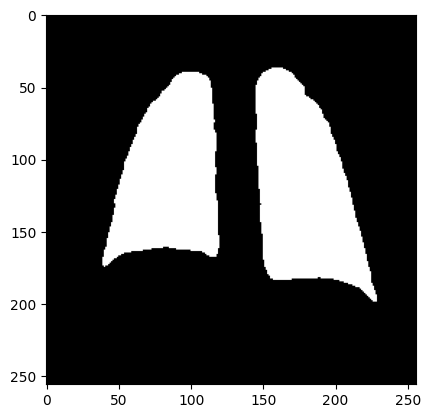

In [82]:
plt.imshow(torch.sigmoid(output[0][0]).cpu()>0.5, cmap="gray")

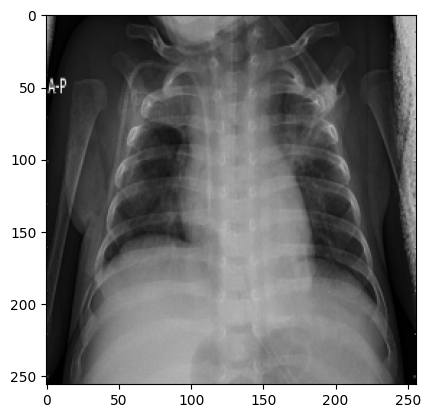

In [83]:
plt.imshow(test_measure_mean[0].permute(1,2,0).cpu())

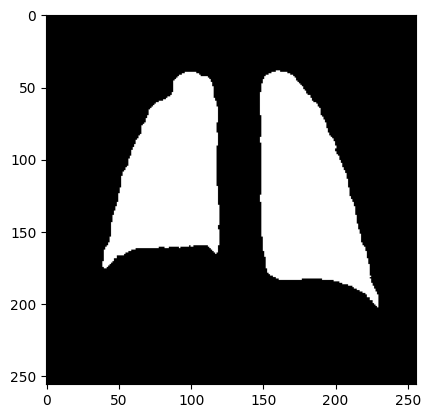

In [84]:
plt.imshow(test_measure_std[0][0].cpu(), cmap="gray")

In [ ]:
sum = 0
for par in model.parameters():
    sum += par.numel()
print(sum)

In [ ]:
def postprocess_image(image):
    predicted_map = np.array(image.detach().cpu())
    predicted_map = np.squeeze(predicted_map)
    predicted_map = predicted_map > 0
    return predicted_map

def saveImage(data, label, predict, path):
    plt.subplot(1,3,1)
    plt.imshow(data)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(label, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(predict, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(path)

def predict():

    if not os.path.exists("/content/drive/MyDrive/Predictions"):
        os.makedirs("/content/drive/MyDrive/Predictions")
    if not os.path.exists("/content/drive/MyDrive/Predictions/Trained on {}".format("Bowl2018")):
        os.makedirs("/content/drive/MyDrive/Predictions/Trained on {}".format("Bowl2018"))

    t = time.time()
    model.eval()
    checkpoint = torch.load("/content/drive/MyDrive/Trained models/LGMNet_BOWL2018.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    perf_accumulator = []
    mIOU = []
    Dice = []
    for batch_idx, (data, target) in enumerate(test_dataloader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        perf_accumulator.append(perf(output, target).item())
        mIOU.append(Fmstric.binary_jaccard_index(torch.sigmoid(output), target>0.5).item())
        Dice.append(torchmetrics.functional.dice(torch.sigmoid(output), target>0.5).item())
        input_image = data[0].permute(1,2,0).cpu().numpy()
        labels = postprocess_image(target)
        predicted_map = postprocess_image(output)
        saveImage(input_image, labels, predicted_map, "/content/drive/MyDrive/Predictions/Trained on {}/dice_{}_{}.jpg".format(
                "Bowl2018",perf_accumulator[-1], batch_idx))
        # cv2.imwrite(
        #     "/content/drive/MyDrive/Predictions/Trained on {}/dice_{}_{}.jpg".format(
        #         "Kvar",perf_accumulator[-1], batch_idx),
        #     predicted_map * 255,
        # )

        if batch_idx + 1 < len(test_dataloader):
            print(
                "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tDice: {:.6f}\tTime: {:.6f}".format(
                    "Predict", 0, batch_idx + 1, len(test_dataloader), 100.0 * (batch_idx + 1) / len(test_dataloader),
                    np.mean(perf_accumulator), np.mean(mIOU), np.mean(Dice), time.time() - t, ), end="", )
        else:
            print(
                "\r{}  Epoch: {} [{}/{} ({:.1f}%)]\tDice: {:.6f}\tmIOU: {:.6f}\tDice: {:.6f}\tTime: {:.6f}".format(
                    "Predict",0, batch_idx + 1, len(test_dataloader), 100.0 * (batch_idx + 1) / len(test_dataloader),
                    np.mean(perf_accumulator), np.mean(mIOU), np.mean(Dice), time.time() - t, ))

    return np.mean(perf_accumulator), np.std(perf_accumulator)

In [ ]:
# predict()

In [ ]:
# img1= cv2.imread("/content/Predictions/Trained on Kvar/dice_0.23350229859352112_86.jpg",0)
# img2 = cv2.imread("/content/Predictions/Trained on Kvar/dice_0.5382550358772278_49.jpg",0)
# img3 = cv2.imread("/content/Predictions/Trained on Kvar/dice_0.7475423812866211_36.jpg",0)

In [ ]:
# plt.subplot(1,3,1)
# plt.imshow(img1, cmap="gray")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1,3,2)
# plt.imshow(img2, cmap="gray")
# plt.xticks([])
# plt.yticks([])
# plt.subplot(1,3,3)
# plt.imshow(img3, cmap="gray")
# plt.xticks([])
# plt.yticks([])
# plt.savefig("test.png")